# Introduction

What we did in this notebook is selecting a small part of the amazon dataset and use it to test the methods we implemented.

Please note that the structure of the notebook has been completely changed compared to Milestone 2.

Please also note that due to time constraints and cluster overload we weren't able to properly test our methods on the cluster.

# Import/Helpers

In [1]:
import os
import findspark
#os.environ['SPARK_HOME'] = '/opt/apache-spark'
os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/2.2.0/libexec/'
findspark.init()
from pyspark import SQLContext, SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics as S
import json
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#compute correlation
def correlation(df, col1, col2, method='pearson'):
    rdd1 = df.select(col1).rdd.map(lambda x: x[0])
    rdd2 = df.select(col2).rdd.map(lambda x: x[0])
    return S.corr(rdd1, rdd2, method)

Creation of a Spark contest.

In [3]:
memory = '6g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

sc = SparkContext()
sqlContext = SQLContext(sc)

# Loading data

We load the data from the json file and rewrite it in parquet format.

The data is a small subset containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food". 

We will use this dataset on our local machine to qualitatively manipulate the data. 

In [ ]:
# No need to run it, already saved the .parquet.

df_review = sqlContext.read.json("reviews_auto_baby_grocery.json")
df_review = sqlContext.read.json("datasets/data.json")
df_review.write.parquet("data.parquet")

The two following methods alter the structure of the Amazon's product metadata and review in order to make it more easy to work on it later on.

We filter the salesRank to have only ranked products. There is two possiblity, either the salesRank is completely none, either the categories are all None. we take care of both cases.

In [ ]:
# No need to run it, already saved the .parquet.

# We flatten the meta dataframe
def flatten(salesRank):
    if salesRank == None:
        return None, None
    else:
        for category, rank in salesRank.asDict().items():
            if rank != None:
                return (category, rank)
    return None, None
flatten = udf(flatten, StructType([StructField("category", StringType()), StructField("rank", IntegerType())]))
df_flattened = meta_df.withColumn("salesRank", flatten("salesRank"))
df_flattened = df_flattened.drop("_corrupt_record")
df_flattened = df_flattened.select(list(set(df_flattened.schema.names) - set(["salesRank", "related"]))+ ["salesRank.*", "related.*"])
df_flattened.write.parquet("metadata.parquet")

In [ ]:
# No need to run it, already saved the .parquet.

# We check that there is no metadata with two ranks
def not_one_or_none(salesRank):
    count = 0
    # If no rank, then false
    if salesRank == None:
        return 0
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return int(count != 1 and count != 0)
not_one_or_none = udf(not_one_or_none, IntegerType())
not_one_or_none = meta_df.withColumn("exactly_one", not_one_or_none("salesRank")).agg(F.sum("exactly_one").alias("sum")).head()[0]
print("There is %.d article with not exactly one category for a rank"%not_one_or_none)

Here we load the metadata and data review.

In [5]:
#this must be run.

df_review = sqlContext.read.parquet("data.parquet")
num_reviews = df_review.count()

In [7]:
#this must be run.

meta_df = sqlContext.read.parquet("metadata.parquet")

Compute the total number of products.

In [8]:
total_products = meta_df.count()
total_products

574167

Compute the ratio between ranked and total products.

In [9]:
ranked_products = meta_df.filter(count()
ranked_products
ratio = ranked_products/total_products
print("ranked_products: " + str(ranked_products) + " total products: " + str(total_products) + " ratio: " + str(ratio))

ranked_products: 574167 total products: 574167 ratio: 1.0


We can notice that in this restricted dataset less than one third of the products is ranked, a fact that makes our rank-based analysis less representative. 

## Part 1: Reviews Feature

The first part of the analysis is dedicated to studying Amazon's reviews feature.

As a first step, we explore some metrics related to reviews: a quantitative one - the number of words per review - and a qualitative one - the helpfulness of a review. 

### Word count

The wordcount is a metric measuring the length of reviews.

In [10]:
wordCount = F.udf(lambda text: len(text.split(" ")), T.IntegerType())

df_review = df_review.withColumn('wordcount', wordCount(df_review["reviewText"]))
df_review.select("wordcount").describe().show()
overall = df_review.select("overall").rdd.map(lambda x: x[0])
wordcount = df_review.select("wordcount").rdd.map(lambda x: x[0])
pearson_corr = correlation(df_review, "overall", "wordcount", method='pearson')
spearman_corr = correlation(df_review, "overall", "wordcount", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

+-------+-----------------+
|summary|        wordcount|
+-------+-----------------+
|  count|          3586370|
|   mean|66.76379821379278|
| stddev|72.96104481688172|
|    min|                1|
|    max|             5019|
+-------+-----------------+

The pearson correlation is -0.090 and the spearman is -0.148


It can be noted the correlation between review rating and length is very low.

(array([  3.57397200e+06,   1.12560000e+04,   9.22000000e+02,
          1.53000000e+02,   4.10000000e+01,   1.30000000e+01,
          4.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          5.00000000e+00]),
 array([  1.00000000e+00,   5.02800000e+02,   1.00460000e+03,
          1.50640000e+03,   2.00820000e+03,   2.51000000e+03,
          3.01180000e+03,   3.51360000e+03,   4.01540000e+03,
          4.51720000e+03,   5.01900000e+03]),
 <a list of 10 Patch objects>)

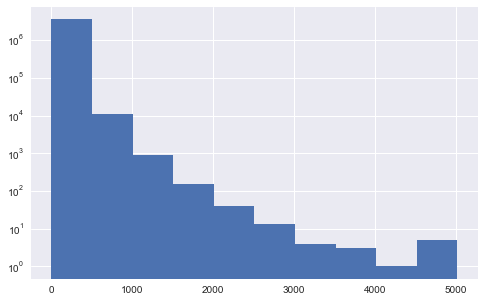

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review.select("wordcount"), log=True)

It seems that in average reviews are short (< 1000 words).

### Helpfulness

The helpfulness is a metric measuring the uselfulness of reviews.

We get the helpfulness of a review by computing the ratio of people that found a review helpful and those that voted. If we have no data, we simply put -1 as a ratio.

In [12]:
df_review = df_review.withColumn("helpfulness", F.when(df_review.helpful.getField(1) > 0, df_review.helpful.getField(0)/df_review.helpful.getField(1)).otherwise(-1))
df_review_helpfulness = df_review.filter(df_review["helpfulness"] > 0.0)

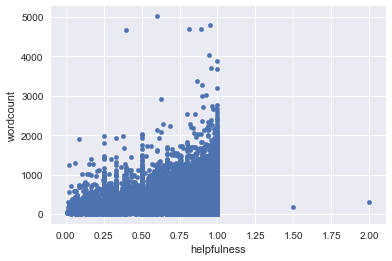

In [13]:
df_review_helpfulness.select("helpfulness", "wordcount").toPandas().plot.scatter("helpfulness", "wordcount")

In [14]:
spearman_corr = df_review_helpfulness.select("helpfulness", "wordcount").toPandas().corr(method = "spearman")
spearman_corr

,helpfulness,wordcount
helpfulness,1.000000,-0.100372
wordcount,-0.100372,1.000000


In [15]:
df_review_helpfulness.select("helpfulness").describe().show()

+-------+-------------------+
|summary|        helpfulness|
+-------+-------------------+
|  count|            1168344|
|   mean| 0.8738595187003801|
| stddev| 0.2130394077778486|
|    min|0.00847457627118644|
|    max|                2.0|
+-------+-------------------+



There seems to have some discrepancies amongst the ratio, since the max is at 2.0. We will check that it does not occur too often and may drop the data in the future.

In [16]:
df_review_outliers = df_review_helpfulness.filter(df_review["helpfulness"] > 1.0)

df_review_helpfulness = df_review_helpfulness.filter(df_review["helpfulness"] <= 1.0)

df_review_outliers.select("helpful").show()

+-------+
|helpful|
+-------+
| [2, 1]|
| [3, 2]|
+-------+



Since only two reviews have problems, we will simply filter them out.

We then look at some distribution of helpfulness and rating.

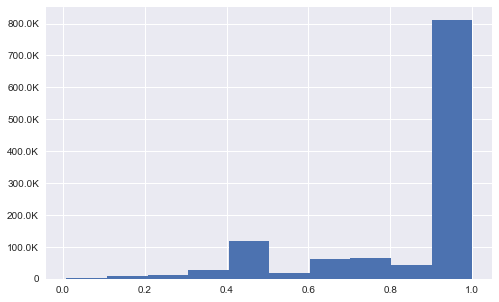

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review_helpfulness.select("helpfulness"));

In general the helpfulness is very high - between 0.9 and 1. Maybe people generally vote only if the review was helpful?

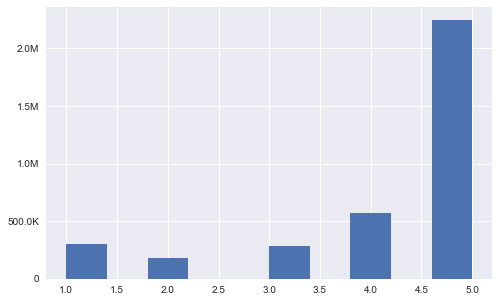

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_review.select("overall"));

Here we compute correlation between the review's rating of the product and the review helpfulness.

In [19]:
df_review_helpfulness.select("overall", "helpfulness").toPandas().corr(method = 'spearman')

,overall,helpfulness
overall,1.000000,0.260896
helpfulness,0.260896,1.000000


Here we compute the correlation between a product ranking and -respectively - the number of reviews it has, the average of the reviews helpfulness, the average of the reviews rating.

In [20]:
output_df = meta_df[['asin', 'rank']]

joined_df = meta_df.join(df_review, 'asin')
grouped_df = joined_df.groupBy('asin')

review_count_df = grouped_df.count()
mean_helpfulness_df = grouped_df.mean('helpfulness', 'overall')
output_df = output_df.join(review_count_df, 'asin').join(mean_helpfulness_df, 'asin')
rank_count_correlation = output_df.corr('rank', 'count', method='pearson')
rank_helpfulness_correlation = output_df.corr('rank', 'avg(helpfulness)', method='pearson')
rank_overall_correlation = output_df.corr('rank', 'avg(overall)', method='pearson')
print(rank_count_correlation, rank_helpfulness_correlation, rank_overall_correlation)

-0.04157114441441377 0.019204825322910183 -0.015419679531976597


With these three correlations we aren't able to draw any meaningful conclusion.

## influence of reviewer personality

We get the count of review of distinct article per reviewer and filter those that have less than 5 review.

In [21]:
df_count = df_review.groupBy("reviewerID").agg(F.countDistinct("asin").alias('review_count')).filter("`review_count` >= 5")

(0, 25000)

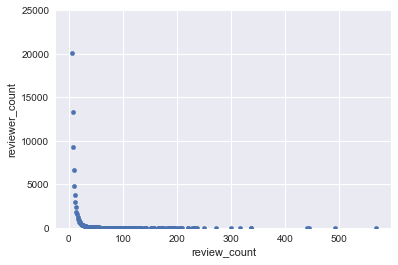

In [22]:
df_count_final = df_count.groupby('review_count').agg(F.count("reviewerID").alias('reviewer_count')).orderBy("review_count")

ax = df_count_final.select('reviewer_count', 'review_count').toPandas().plot.scatter('review_count', 'reviewer_count')
ax.set_ylim(0, 25000)

We get all reviews of reviewers with more than 5 articles.

In [23]:
df_filtered = df_review.join(df_count, on='reviewerID').drop('count')
num_five_reviews = df_filtered.count()
print("We have %.d, i.e. %.3f%% of review who belongs to reviewer with 5 or more reviews"%(num_five_reviews, num_five_reviews/num_reviews))

We have 996378, i.e. 0.278% of review who belongs to reviewer with 5 or more reviews


We compute the average grade for each reviewer.

In [24]:
average_std_score = df_filtered.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
average_std_score.cache().count()

109193

Here are some statistic concerning the average grade for each reviewer.

The first row contains the total number of reviewer considered.

The second row contains the mean of the reviewers' averages grades (left) and the standard deviation of said mean (right).

The third row contains the mean of the reviewers' standard deviations (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's lower grades (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's higher grades (left) and the standard deviation of said mean (right).

In [25]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|            109193|            109193|
|   mean|4.2834718157516365|0.9022456674075624|
| stddev|0.6049040387948184|0.5699621176391938|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



We then plot the average grade for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such mean ranking on the y-axis.

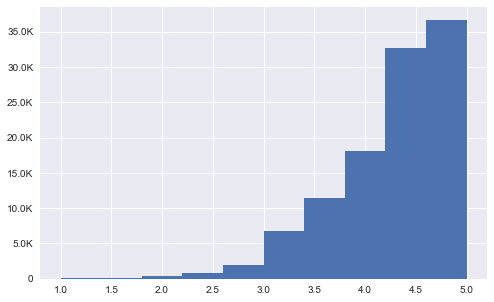

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.select("mean"));

It can be noted that reviewers tend to give high ratings.

We then plot the average standard deviation for each reviewer through histograms, with the grade on the x-axys and the number of reviewers who have such average standard deviation on the y-axis.

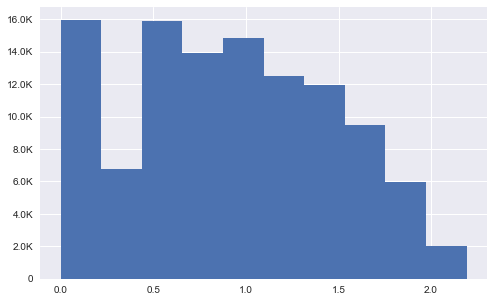

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.select("std"));

It can be noted that the majority of reviewers tend to have either a very small standard deviation (0-0.25) or a standard deviation between 0.5 and 1.5. The number of people with an higher standard deviation are sensibily less.

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 52.71% of reviewer with std < 0.25


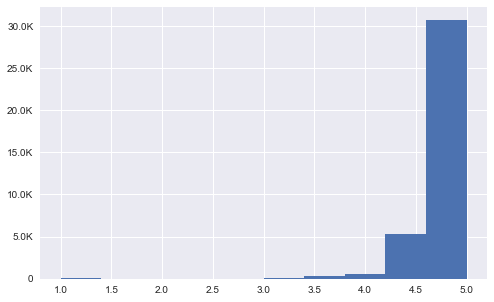

In [28]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.9).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, average_std_score.filter(average_std_score.std < 0.6).select("mean"));

It can be noted that people with a small standard deviation, i.e. people who tend to always give the same rating, tend to give only very high rating (>4.5).

In conclusion, we have hints that there's a certain bias related to reviewers' personality and habits. 
The fact that the mean of the average reviewer rating is so high for example could make us think that people tend to rate the product they're satisfied with and not those they're unsastisfied with.
The fact that the reviewers with little standard deviation tend to give high ratings also speaks in that direction.

## brand fidelity/hate

We load the metadata datas and only keep the article number and the brand that are not null, since we are interested in brands.

We then join the dataframe of reviews with the metadata and display some stats.

In [29]:
df_meta = sqlContext.read.json("meta_auto_baby_grocery.json")
df_meta_brand = df_meta.select("asin", "brand").dropna()

df_with_brand = df_filtered.join(df_meta_brand, on='asin')
num_reviews_with_brand = df_with_brand.count()

print("We have %.d, which represents %.3f%% of review with a brand and who belongs to reviewer with 5 or more reviews"%(num_reviews_with_brand, num_reviews_with_brand/num_reviews*100))
print("We have %.3f%% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand "%(num_reviews_with_brand/num_five_reviews*100))

We have 599153, which represents 16.706% of review with a brand and who belongs to reviewer with 5 or more reviews
We have 60.133% of review amongst those who belongs to reviewer with 5 or more reviews that have a brand 


We can see that once again we loose a lot of reviews with this approach, but it is still an interesting number to work with.

Then we group by brand and reviewer, compute some stats and filter out all reviewers that have less than 5 reviews for a specific brand.

In [30]:
df_brand_reviewer = df_with_brand.groupBy(["brand", "reviewerID"]).agg(F.count("overall").alias("count"), F.avg("overall").alias("mean"), F.stddev("overall").alias("std")).filter("`count` >= 5")
brand_reviewers_count = df_brand_reviewer.cache().count()
print("We have %.d brand/reviewers tuples"%(brand_reviewers_count))

We have 1602 brand/reviewers tuples


We then show some stats about the mean and std.

+-------+------------------+------------------+------------------+
|summary|             count|              mean|               std|
+-------+------------------+------------------+------------------+
|  count|              1602|              1602|              1602|
|   mean| 6.300249687890138| 4.508185595174844|0.5331499357349924|
| stddev|2.4612651820035443|0.6345228590350631|0.5522432344415494|
|    min|                 5|               1.0|               0.0|
|    max|                36|               5.0|2.1908902300206643|
+-------+------------------+------------------+------------------+



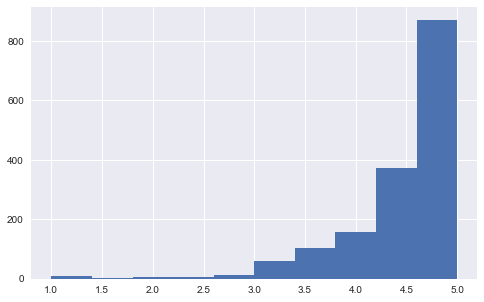

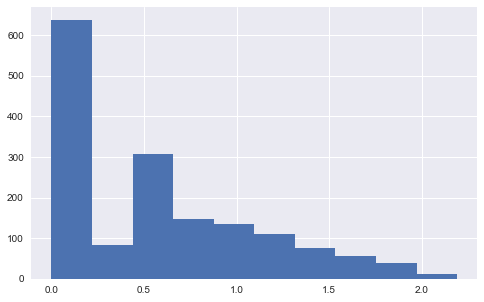

In [31]:
df_brand_reviewer.select("count", "mean", "std").describe().show()
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("mean"));
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df_brand_reviewer.select("std"));

By comparing qualitatively those graphs with the one from Question 2, we can see that the ratings seems to be having less deviation, showing a tendency to love/hate toward a brand.

We try to see if there is an obvious correlation between number of reviews for a brand and the mean rate:

In [32]:
pearson_corr = correlation(df_brand_reviewer, "count", "mean", method='pearson')
spearman_corr = correlation(df_brand_reviewer, "count", "mean", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

The pearson correlation is 0.038 and the spearman is 0.018


These correlation aren't meaningful.

## Part 2: advertising features

This function allows to explode a column whose data type is a structure in a dataframe.

In [33]:
def explode_and_join(column_to_explode):
    q4_meta_df = meta_df.select("asin", "rank", F.explode(column_to_explode).alias("paired_product")).dropna(how='any')
    q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias("paired_asin"), F.col("rank").alias("paired_rank")), F.col("paired_product") == F.col("paired_asin"), "inner")
    return q4_joined_meta_df

This function explodes two columns of a dataframe.

In [34]:
def explode_and_join_tuple(column_to_explode_1, alias_1, column_to_explode_2, alias_2):
    q4_meta_df = meta_df.select("asin", "rank", alias_2, F.explode(column_to_explode_1).alias(alias_1)).dropna(how='any')
    q4_meta_df = q4_meta_df.select("asin", "rank", alias_1, F.explode(column_to_explode_2).alias(alias_2)).dropna(how='any')
    q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias(alias_1 + "_asin"), F.col("rank").alias(alias_1 + "_rank")), F.col(alias_1) == F.col(alias_1 + "_asin"), "inner").dropna(how='any')
    q4_joined_meta_df = q4_joined_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias(alias_2 + "_asin"), F.col("rank").alias(alias_2 + "_rank")), F.col(alias_2) == F.col(alias_2 + "_asin"), "inner").dropna(how='any')
    #q4_joined_meta_df = q4_meta_df.alias("df1").join(q4_meta_df.alias("df2").select(F.col("asin").alias("paired_asin"), F.col("rank").alias("paired_rank")), F.col("paired_product") == F.col("paired_asin"), "inner")
    return q4_joined_meta_df.limit(1000)

As a first thing, we explode the 'bought together' column of the dataframe. Each row of the resulting dataframe will have too product ranking: "rank", which is the rank of the original product, and "paired rank", which is the rank of o product which was bought together with the original.

In [35]:
bought_together_df = explode_and_join("bought_together")

Following this, we plot the "rank" and "paired_rank".

(0, 1000000)

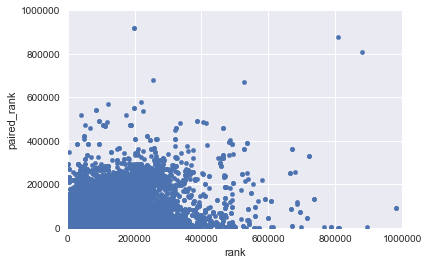

In [36]:
ax = bought_together_df.toPandas().plot.scatter("rank", "paired_rank")
ax.set_xlim(0, 1000000)
ax.set_ylim(0, 1000000)

Then compute their Spearman correlation.

In [37]:
rank_bought_together_correlation = bought_together_df.select('rank', 'paired_rank').toPandas().corr( method='spearman')
rank_bought_together_correlation

,rank,paired_rank
rank,1.000000,0.413227
paired_rank,0.413227,1.000000


The Spearman correlation has a remarkable value.

We do the same with the 'also_bought' feature.

In [38]:
also_bought_df = explode_and_join("also_bought")

And compute its correlation.

In [39]:
rank_also_bought_correlation = also_bought_df.corr('rank', 'paired_rank', method='pearson')
rank_also_bought_correlation

0.1396220471310883

This correlation is too weak to be meaningful.

We do the same with the 'also_viewed' feature.

In [40]:
also_viewed_df = explode_and_join("also_viewed")

In [41]:
rank_also_viewed_correlation = also_viewed_df.corr('rank', 'paired_rank', method='pearson')
rank_also_viewed_correlation

0.10400314137543323

This correlation is too weak to be meaningful.

In [42]:
#tuple_df = explode_and_join_tuple("also_bought", "also_bought", "bought_together", "bought_together")

#also_bought_bought_together_correlation = tuple_df.select("also_bought", "bought_together").toPandas().corr(method = 'spearman')

#also_bought_bought_together_correlation

#tuple_df = explode_and_join_tuple("also_bought", "also_bought", "also_viewed", "also_viewed")

#also_bought_also_viewed_correlation = tuple_df.select("also_bought", "also_viewed").toPandas().corr(method = 'spearman')

#print(also_bought_bought_together_correlation, also_bought_also_viewed_correlation)

Here we tried to explode two columns of the dataset to compute the intra advertising feature correlation. However, due to the exponential compelexity of the operation, we failed.

## Question 6: product categorization

Here we divise the products per category and computet the number of review, average helpfulness of the reviews and average rating of the reviews per category.

In [43]:
def explode_categories():
    q6_meta_df = meta_df.select("asin", "rank", F.explode("categories").alias("category")).select("asin", "rank", F.explode("category").alias("category")).dropna(how='any')
    review_count_per_category = q6_meta_df.join(df_review_helpfulness, "asin").groupby("category").agg(F.count("asin"), F.avg("helpfulness"), F.mean("overall"))
    review_count_per_category = review_count_per_category.orderBy("count(asin)", ascending = False)
    return review_count_per_category
    
review_count_per_category = explode_categories()
review_count_per_category.show()

+--------------------+-----------+------------------+------------------+
|            category|count(asin)|  avg(helpfulness)|      avg(overall)|
+--------------------+-----------+------------------+------------------+
|Grocery & Gourmet...|     397182|0.8713333835046126| 4.098869032332784|
|          Automotive|      39008|0.8705645207134524| 3.968929450369155|
|           Beverages|       9700|0.8275298792472365| 4.070618556701031|
|   Tools & Equipment|       9076|0.8599665631980292| 3.854451300132217|
|    Cooking & Baking|       7774|0.8618028359465484| 4.129662979161307|
|Motorcycle & Powe...|       6182|0.8843638061572804| 3.981559365901003|
|            Car Care|       4964| 0.863627100022141| 4.094681708299758|
|Canned, Dry & Pac...|       4949|0.8490505208983794| 4.256415437462113|
|Interior Accessories|       4613|0.9017053963645572|3.7539562107088664|
|     Protective Gear|       4580|0.8806680793666237|3.9120087336244542|
|                 Tea|       4165|0.809704059163584

The we compute some statistics.

In [44]:
review_count_per_category.describe().show()

+-------+------------------+------------------+-------------------+------------------+
|summary|          category|       count(asin)|   avg(helpfulness)|      avg(overall)|
+-------+------------------+------------------+-------------------+------------------+
|  count|              1414|              1414|               1414|              1414|
|   mean|              null|462.56577086280055| 0.8948326397286446|3.9825035430768634|
| stddev|              null|10625.983535790452|0.10490565316858601|0.8490247409592849|
|    min|12-Month Financing|                 1|               0.25|               1.0|
|    max|    Yellow Mustard|            397182|                1.0|               5.0|
+-------+------------------+------------------+-------------------+------------------+



It can be noted that the average helpfulness is high (0.9) and the average overall rating too (4.00).

In [45]:
correlation1 = review_count_per_category.select('avg(helpfulness)', 'avg(overall)').toPandas().corr(method = 'spearman')
correlation1

,avg(helpfulness),avg(overall)
avg(helpfulness),1.000000,0.291112
avg(overall),0.291112,1.000000


There's a weak correlation between average helpfulness and average overall rating, again. 

In [46]:
correlation2 = review_count_per_category.select('avg(helpfulness)', 'count(asin)').toPandas().corr(method = 'spearman')
correlation2

,avg(helpfulness),count(asin)
avg(helpfulness),1.000000,-0.447893
count(asin),-0.447893,1.000000


there's a remarkable negative correlation between the average helpfulness of reviews and the number of review associated to a category.

In [47]:
correlation3 = review_count_per_category.select('avg(overall)', 'count(asin)').toPandas().corr(method = 'spearman')
correlation3

,avg(overall),count(asin)
avg(overall),1.000000,-0.166572
count(asin),-0.166572,1.000000


There's a barely noticeable correlation between the overall rating and the number of reviews.